# S-MODE Open Data Workshop

This tutorial goes through checking, downloading, preprocessing, visualizing and combining different S-MODE dataset.
We choose to do that with surface-drifters data and DopplerScatt, but many of the skills covered in this tutorial can also be applied to other dataset.


## Downloading S-MODE data

Go to https://podaac.jpl.nasa.gov/S-MODE

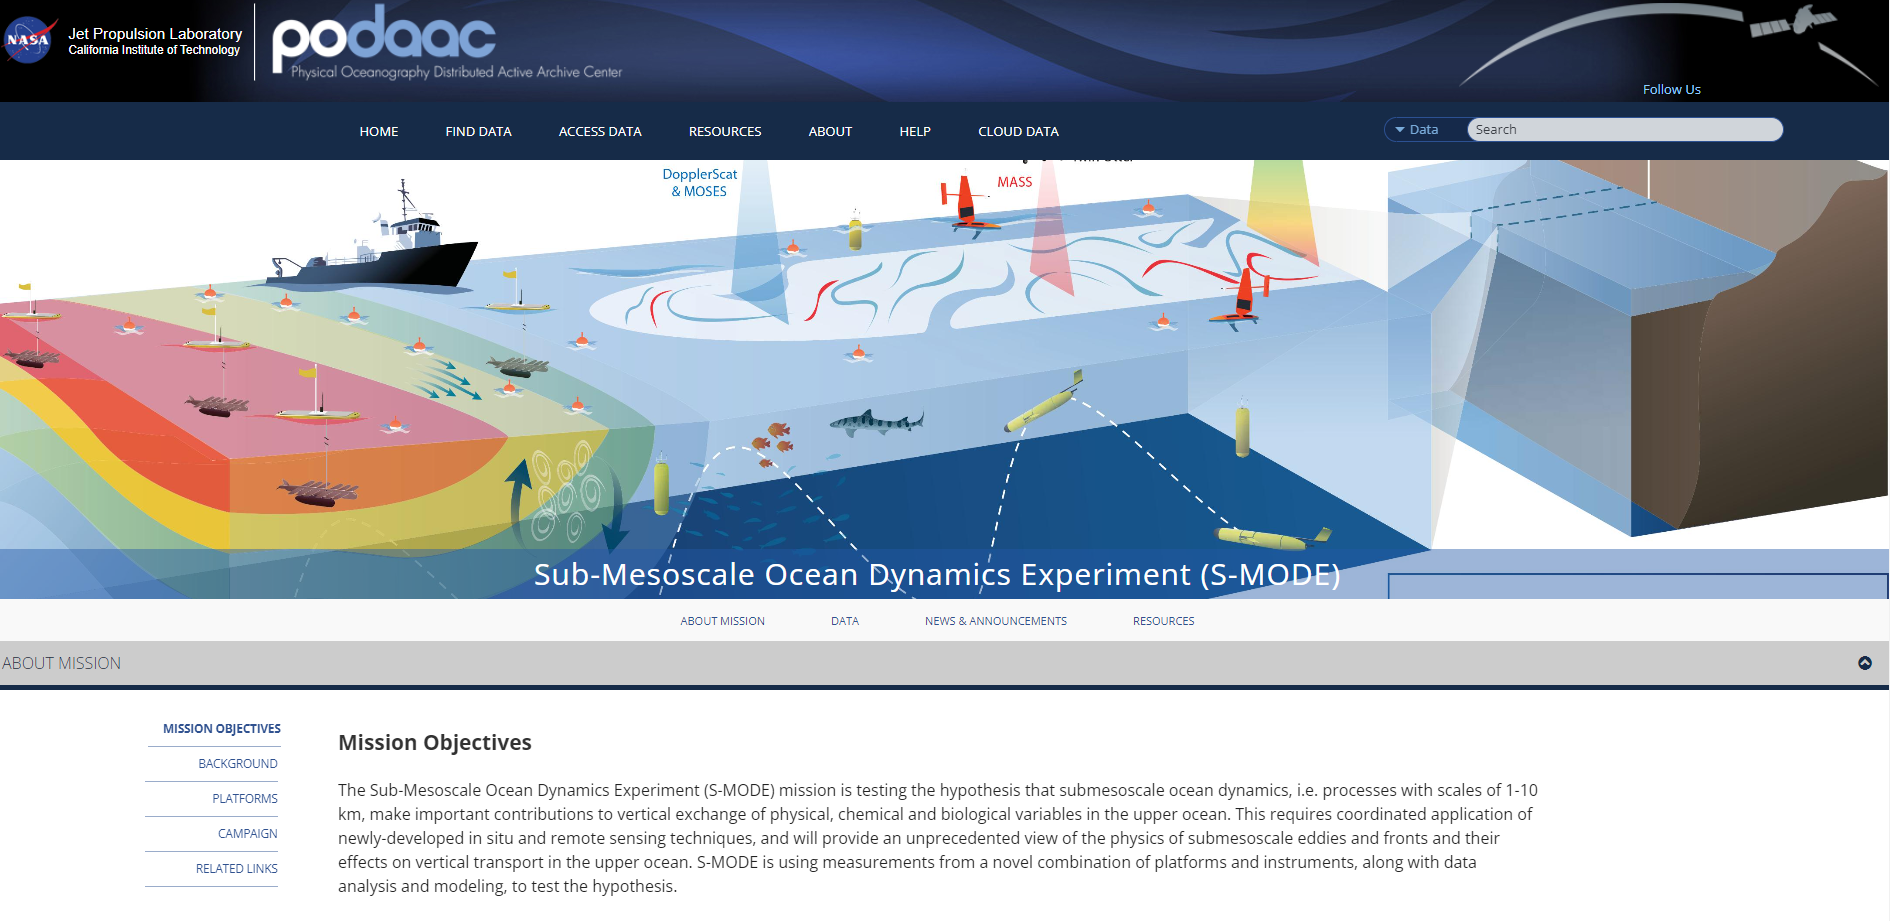

In the **Data** tab, you can check the list of the available datasets:

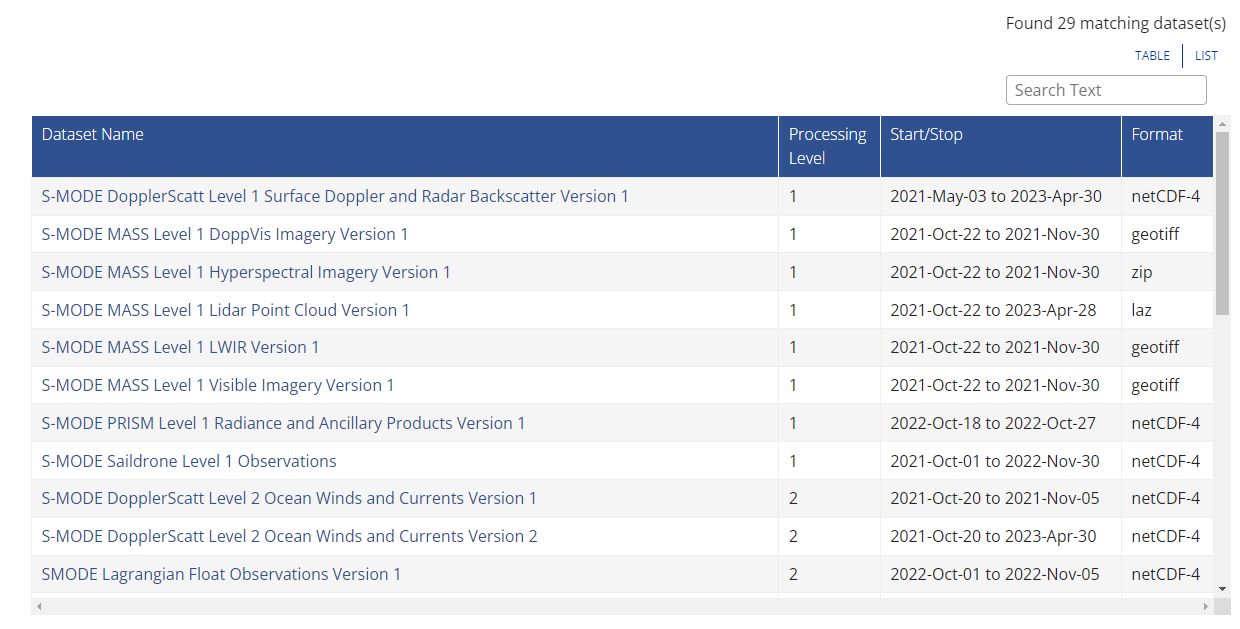


If we select, for instance, the version 2 of the DopplerScatt data, this is going to open a page with all the information about the dataset. In particular, we will need the DOI to access and download it using the `earthaccess` engine.

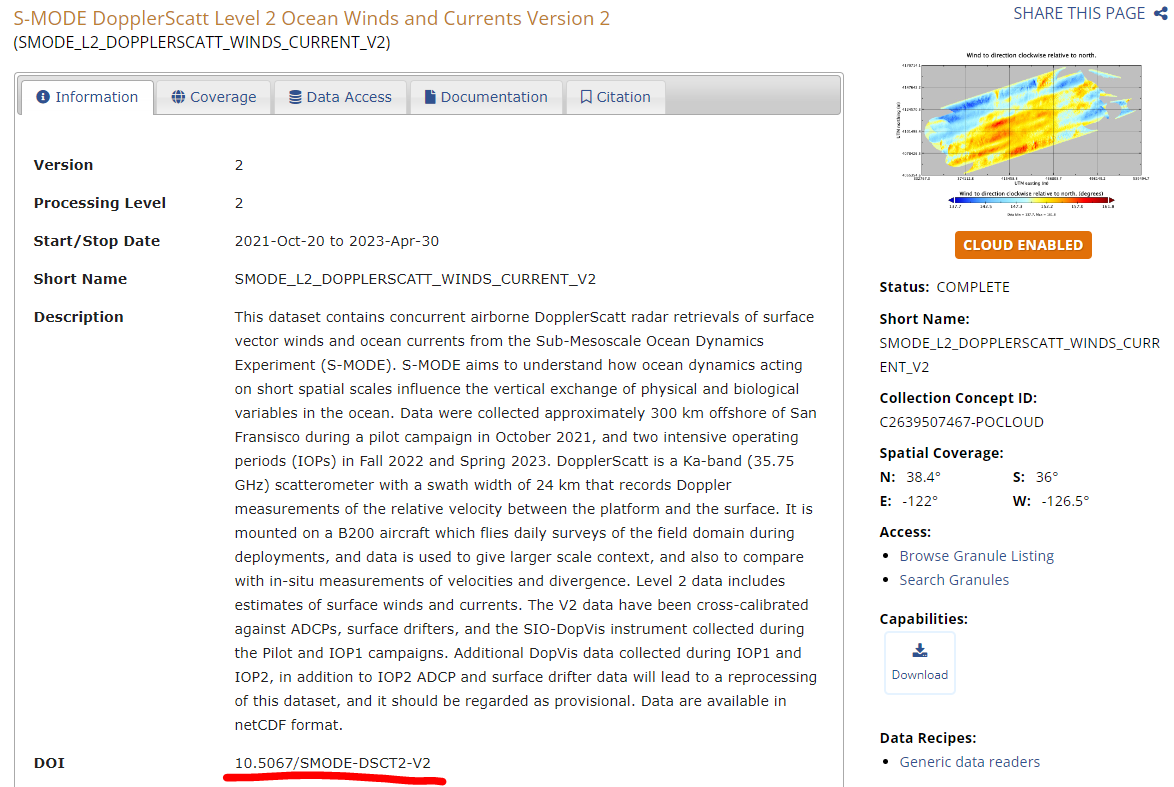

Thus, let's first import the needed packages for downloading the dataset. The last two lines do the authentication to EarthData.
If you don't have a login, first create one and come back to this tutorial. Once you have it, the following code cell will ask for your username and password to authenticate to EarthData.

In [1]:
import earthaccess
from earthaccess import Auth, Store

# Initialize and attempt login
auth = Auth()
auth.login(strategy="interactive")

Enter your Earthdata Login username:  iuryt
Enter your Earthdata password:  ········


Once you are in the system, now we can do all sort of search and download of the data. For this case, let's restrict our searches to the IOP1, that occurred in 2022. We then search by the DOI of the DopplerScatt dataset at this specific timerange.

In [2]:
time_range = ("2022-01-01", "2022-12-31") #IOP1
results = earthaccess.search_data(
    doi = "10.5067/SMODE-DSCT2-V2",
    cloud_hosted = True,
    temporal = time_range
)

# Download data files
store = Store(auth)
files = store.get(results, "../data/external/")

Granules found: 17
 Getting 17 granules, approx download size: 0.61 GB


SUBMITTING | :   0%|          | 0/17 [00:00<?, ?it/s]

File SMODE_IOP1_dopplerscatt_20221010_111816.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221011_081838.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221011_142336.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221012_130829.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221013_125949.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221016_131046.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221018_131254.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221019_130534.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221014_131151.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221020_121649.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221021_124451.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221023_120546.tomoL2CF_v2.nc already downloaded
File SMODE_IOP1_dopplerscatt_20221024_122835.tomoL2C

PROCESSING | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/17 [00:00<?, ?it/s]

<br>
<br>
Now let's do the same for surface-drifter data.

In [3]:
results = earthaccess.search_data(
    doi = "10.5067/SMODE-DRIFT",
    cloud_hosted = True,
    temporal = time_range
)

# Download data files
store = Store(auth)
files = store.get(results, "../data/external/")

Granules found: 55
 Getting 55 granules, approx download size: 0.01 GB


SUBMITTING | :   0%|          | 0/55 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/55 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/55 [00:00<?, ?it/s]

## Drifter-data loading, processing and visualization 

Now let's play a little bit with the drifter data.
We start by using `glob` to list all files with `surface_drifter` in the name.

In [252]:
from glob import glob

fnames = glob("../data/external/*surface_drifter*")
fnames.sort()

fnames[:5]

['../data/external/SMODE_IOP1_surface_drifter_0-4427782.nc',
 '../data/external/SMODE_IOP1_surface_drifter_0-4427807.nc',
 '../data/external/SMODE_IOP1_surface_drifter_0-4431769.nc',
 '../data/external/SMODE_IOP1_surface_drifter_0-4431967.nc',
 '../data/external/SMODE_IOP1_surface_drifter_0-4433868.nc']

Now lets use the power of `xarray` to load and look at the first file on the list.

In [266]:
import xarray as xr

ds = xr.open_dataset(fnames[16])
ds

<xarray.Dataset>
Dimensions:          (time: 7065)
Coordinates:
  * time             (time) datetime64[ns] 2022-10-16T18:53:03 ... 2022-11-10...
    latitude         (time) float64 ...
    longitude        (time) float64 ...
Data variables:
    position_QCflag  (time) float64 ...
Attributes: (12/54)
    DOI:                           10.5067/SMODE-DRIFT
    shortname:                     SMODE_LX_DRIFTER_POSITIONS_V1
    title:                         S-MODE IOP1 Field Campaign Fall 2022 Posit...
    summary:                       S-MODE Drifter 0-4439466 was deployed from...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN CIRCULATION...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    ...                            ...
    geospatial_lat_max:            37.23449
    geospatial_lon_min:            -125.02075
    geospatial_lon_max:            -9.3046
    time_coverage_start:           2022-10-16T18:53:03Z
    time_coverage_end:             2022-11-10T21:40:51Z
    time_coverage_duration:        P25DT2H47M48S

The data has a single dimension in time, only one variable for the quality control flag and three coordinates (time, latitude and longitude).
We can plot it in different ways, but for a line plot we select the latitude and plot it against longitude to see the trajectory of this particle.

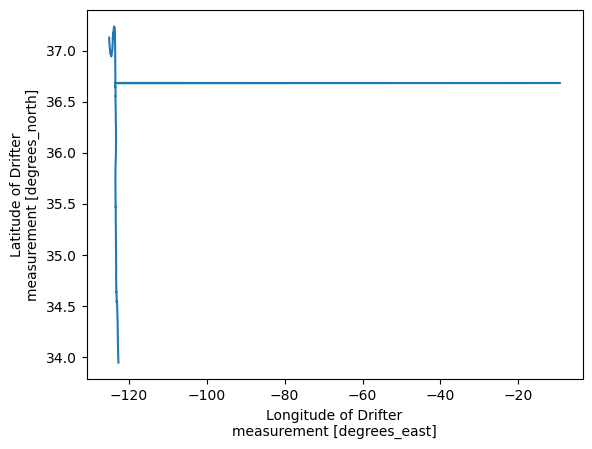

In [267]:
ds['latitude'].plot(x = 'longitude')

This doesn't looks nice. There is something wrong with the data.
Let's check the quality control variable.

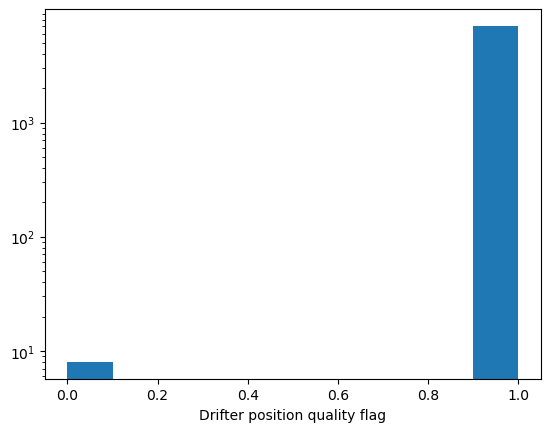

In [269]:
ds["position_QCflag"].plot.hist(yscale = "log");

Now we can remove all bad data with the `.where` method. 

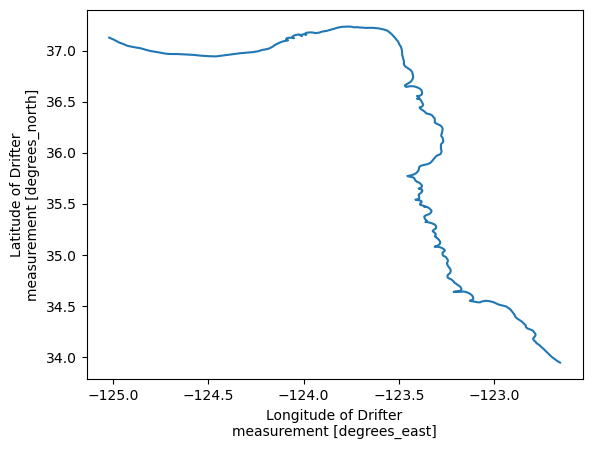

In [271]:
ds = ds.where(ds["position_QCflag"] == 1, drop = True)
ds['latitude'].plot(x = 'longitude')

It looks better, but we can do even better by matching all drifters.
As drifters can start at different times and have different resolution, we might need to change the main dimension to observations in general and keep time as a coordinate before merging all drifters. The cell below imports `numpy` and create a new dimensiona and coordinate `obs`, by which we will use to concatenate all drifter files.

In [274]:
import numpy as np

ds["obs"] = ("time", np.arange(ds["time"].size))
ds = ds.swap_dims(time = "obs")
ds

<xarray.Dataset>
Dimensions:          (obs: 7057)
Coordinates:
    time             (obs) datetime64[ns] 2022-10-16T18:53:03 ... 2022-11-10T...
    latitude         (obs) float64 37.13 37.13 37.13 37.12 ... 33.95 33.95 33.94
    longitude        (obs) float64 -125.0 -125.0 -125.0 ... -122.7 -122.7 -122.7
  * obs              (obs) int64 0 1 2 3 4 5 6 ... 7051 7052 7053 7054 7055 7056
Data variables:
    position_QCflag  (obs) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes: (12/54)
    DOI:                           10.5067/SMODE-DRIFT
    shortname:                     SMODE_LX_DRIFTER_POSITIONS_V1
    title:                         S-MODE IOP1 Field Campaign Fall 2022 Posit...
    summary:                       S-MODE Drifter 0-4439466 was deployed from...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN CIRCULATION...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    ...                            ...
    geospatial_lat_max:            37.23449
    geospatial_lon_min:            -125.02075
    geospatial_lon_max:            -9.3046
    time_coverage_start:           2022-10-16T18:53:03Z
    time_coverage_end:             2022-11-10T21:40:51Z
    time_coverage_duration:        P25DT2H47M48S

Now let's create a function to perform this pre-processing and use it on the `open_mfdataset` function.
The cell below load all drifter data one by one, apply the `preprocess` function and concatenate over a new dimension called `drifter`.
The method `.load()` loads the data into memory.

In [275]:
def preprocess(ds):
    ds = ds.where(ds["position_QCflag"] == 1, drop = True)
    ds["obs"] = ("time", np.arange(ds["time"].size))
    ds = ds.swap_dims(time = "obs")
    return ds

drifters = xr.open_mfdataset(fnames, preprocess = preprocess, concat_dim = "drifter", combine = "nested").load()
drifters

<xarray.Dataset>
Dimensions:          (obs: 8990, drifter: 55)
Coordinates:
  * obs              (obs) int64 0 1 2 3 4 5 6 ... 8984 8985 8986 8987 8988 8989
    time             (drifter, obs) datetime64[ns] 2022-10-10T02:46:30 ... NaT
    latitude         (drifter, obs) float64 37.08 37.08 37.08 ... nan nan nan
    longitude        (drifter, obs) float64 -124.8 -124.8 -124.8 ... nan nan nan
Dimensions without coordinates: drifter
Data variables:
    position_QCflag  (drifter, obs) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
Attributes: (12/54)
    DOI:                           10.5067/SMODE-DRIFT
    shortname:                     SMODE_LX_DRIFTER_POSITIONS_V1
    title:                         S-MODE IOP1 Field Campaign Fall 2022 Posit...
    summary:                       S-MODE Drifter 0-4427782 was deployed from...
    keywords:                      EARTH SCIENCE > OCEANS > OCEAN CIRCULATION...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    ...                            ...
    geospatial_lat_max:            37.08094
    geospatial_lon_min:            -124.78458
    geospatial_lon_max:            -123.23085
    time_coverage_start:           2022-10-10T02:46:30Z
    time_coverage_end:             2022-10-17T08:59:08Z
    time_coverage_duration:        P7DT6H12M38S

Let's try to plot all drifters just like we did for the first one. We can set the color by the drifter number, but as we have so many drifters, don't forget to set `add_legend = False`.

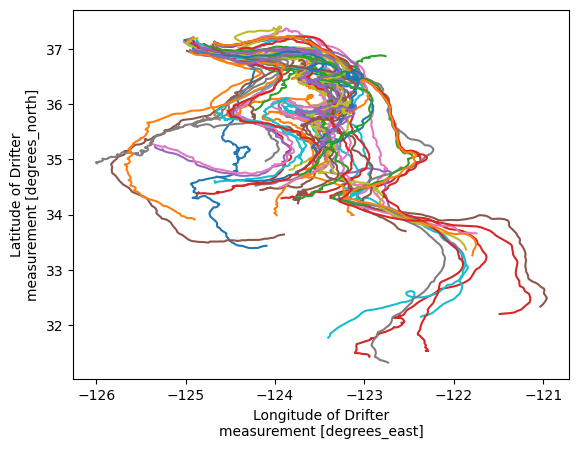

In [276]:
drifters['latitude'].plot(x = 'longitude', hue = "drifter", add_legend = False);

That looks promising! Now let't estimate the velocity from drifter's position, i.e.

$\vec{u} = \begin{vmatrix}\dfrac{\partial x}{\partial t} \\ \dfrac{\partial y}{\partial t} \end{vmatrix}$

But our `x` and `y` are in longitude and latitude degrees.
We can estimate the derivative in $m / s$ by:

$$
\vec{u} = 
k \begin{vmatrix}
\cos(\theta) \dfrac{\partial\phi}{\partial t}\\
\dfrac{\partial\theta}{\partial t}\\
\end{vmatrix}
$$

for $\theta$ being the latitude, $\phi$ the longitude and $k = 111.195\times10^3~m / ^\circ$ the coefficient to convert from degrees to meters.
To do that, we use the method `.differentiate` from `xarray`, which applies second order central 
difference to the data in one coordinates.
If we apply that to `obs` the spacing is constant and 1, thus:

$$
\dfrac{\partial\xi}{\partial t} = \dfrac{\dfrac{\partial\xi}{\partial~\text{obs}}}{\dfrac{\partial t}{\partial~\text{obs}}}
$$

We also use `np.timedelta64` to convert time to seconds

In [281]:
lat2m = 111.195e3
lon2m = lat2m * np.cos(drifters.latitude * np.pi / 180)


dt = ((drifters.time - drifters.time.min("obs", skipna = True)) / np.timedelta64(1, "s")).differentiate("obs")


drifters = drifters.assign(
    u = drifters.longitude.differentiate("obs") * lon2m / dt,
    v = drifters.latitude.differentiate("obs") * lat2m / dt,
)

The `.hist` method can be used again to plot the distributions for the velocity components.

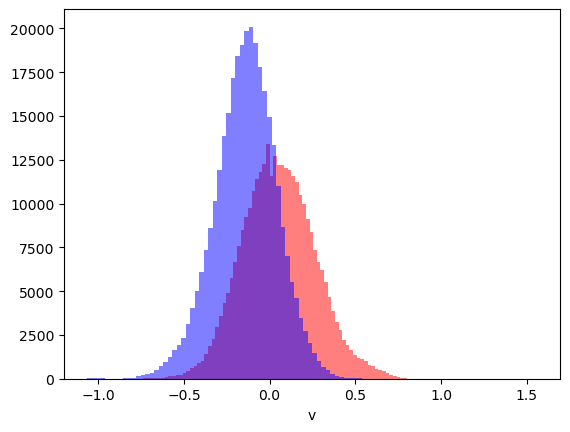

In [303]:
drifters.u.plot.hist(bins = 100, alpha = 0.5, color = "red");
drifters.v.plot.hist(bins = 100, alpha = 0.5, color = "blue");

Now we can plot timeseries of the velocities. We need to import `matplotlib` to be able to construct and set subplots.

[[(-1.0, 1.0)], [(-1.0, 1.0)]]

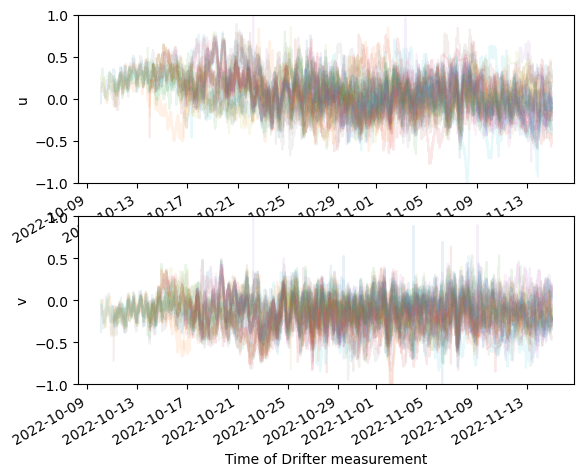

In [309]:
import matplotlib.pyplot

fig, ax = plt.subplots(2, 1)
drifters.u.plot(ax = ax[0], x = "time", hue = "drifter", add_legend = False, alpha = 0.1);
drifters.v.plot(ax = ax[1], x = "time", hue = "drifter", add_legend = False, alpha = 0.1);
[a.set(ylim = [-1, 1]) for a in ax];

We can also make a quiver plot from the velocities of all drifters. Here we are using `.isel` method to subset to each 200 observations.

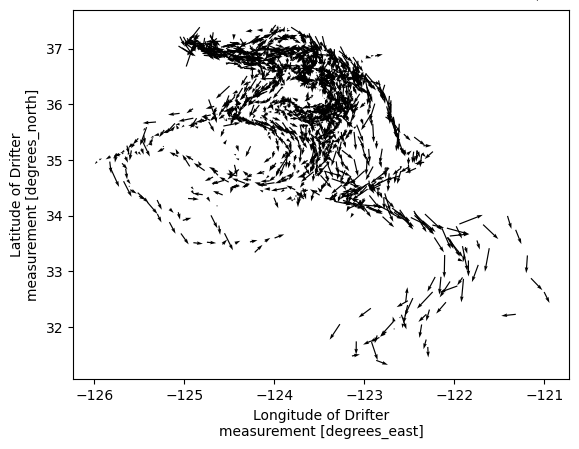

In [310]:
drifters.isel(obs = slice(None, None, 200)).plot.quiver(x = "longitude", y = "latitude", u = "u", v = "v", scale = 15)

We can also use `.groupby` method to group by different properties, for instance, we can measure the average current velocity for each day by:

In [323]:
groups = drifters.groupby(drifters.time.dt.round("D"))
groups

DatasetGroupBy, grouped over 'round'
37 groups with labels 2022-10-10, ..., 2022-11-15.

We can apply methods to the groups such as `.mean` and `.std`, but I love quantiles. Below we show how to plot the median and 25-75% daily spread for zonal velocity from drifters.

[Text(0.5, 1.0, '')]

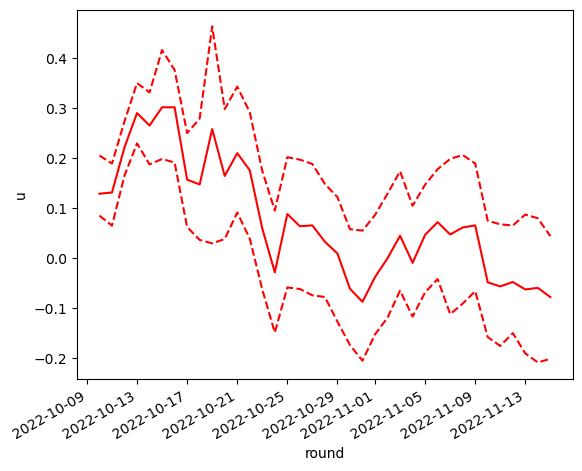

In [337]:
daily_quantiles = groups.quantile([0.25, 0.5, 0.75])

fig, ax = plt.subplots()
c = "red"
daily_quantiles.u.sel(quantile = 0.5).plot(color = c)
daily_quantiles.u.sel(quantile = 0.25).plot(linestyle = "--", color = c)
daily_quantiles.u.sel(quantile = 0.75).plot(linestyle = "--", color = c)
ax.set(title = "")

## Dopplerscatt-data loading, processing and visualization 

Now let's look at the dopplerscatt data. The cell below we check the files we downloaded.

In [388]:

fnames = glob("../data/external/*dopplerscatt*")
fnames.sort()

fnames[:5]

['../data/external/SMODE_IOP1_dopplerscatt_20221010_111816.tomoL2CF_v2.nc',
 '../data/external/SMODE_IOP1_dopplerscatt_20221011_081838.tomoL2CF_v2.nc',
 '../data/external/SMODE_IOP1_dopplerscatt_20221011_142336.tomoL2CF_v2.nc',
 '../data/external/SMODE_IOP1_dopplerscatt_20221012_130829.tomoL2CF_v2.nc',
 '../data/external/SMODE_IOP1_dopplerscatt_20221013_125949.tomoL2CF_v2.nc']

Let's take a look at the 16th file (this was picked because the data looks very cool!).

In [389]:
ds = xr.open_dataset(fnames[15])
ds

<xarray.Dataset>
Dimensions:                                      (x: 852, y: 308, line: 12)
Coordinates:
  * x                                            (x) float64 2.923e+05 ... 4....
  * y                                            (y) float64 4.039e+06 ... 4....
  * line                                         (line) int32 2 3 4 ... 11 12 13
    mean_line_time                               (line) datetime64[ns] ...
Data variables: (12/35)
    latitude                                     (y, x) float32 ...
    longitude                                    (y, x) float32 ...
    nobs_all_lines                               (y, x) float64 ...
    mean_observation_time                        (line, y, x) datetime64[ns] ...
    min_line_time                                (line) datetime64[ns] ...
    mean_observation_time_all_lines              (y, x) datetime64[ns] ...
    ...                                           ...
    u_current_error_all_lines                    (y, x) float32 ...
    v_current_error_all_lines                    (y, x) float32 ...
    cross_track_distance                         (line, y, x) float32 ...
    current_cross_track_distance_line_flag       (line, y, x) float64 ...
    current_cross_track_distance_all_lines_flag  (y, x) float64 ...
    spatial_ref                                  int32 ...
Attributes: (12/85)
    creator_type:                  group
    creator_name:                  E. Rodriguez, A. Wineteer, T. Gal, D. Perk...
    creator_institution:           NASA/JPL
    creator_email:                 ernesto.rodriguez@jpl.nasa.gov
    creator_url:                   https://scholar.google.com/citations?user=...
    creator_role:                  Researcher
    ...                            ...
    parallel_scale:                0.9997839978496049
    svradial_sigma_max:            0.5
    sin_phi_max:                   0.95
    svradial_max:                  3.0
    geospatial_bounds_crs:         EPSG:32610
    uuid:                          04e72f09-f185-479b-80d8-b2f183f32a39

This data is big and has 35 variables. There are three dimensions for `_line` variables, which `line` being the aircraft passing.
We here will work with the combination of all passings of the aircraft with the optimal estimation of the surface velocities.
The data can both be accessed by `ds[variable]` as `ds.variable` and the code below plot the wind speed with color limits based on the 2nd and 98th percentiles instead of the extreme values (`robust = True`) and with x and y coordinates in the same scale (`ax.axis('scaled')`).

(292223.9500801831, 462587.1433237919, 4038690.994225785, 4100277.6884933207)

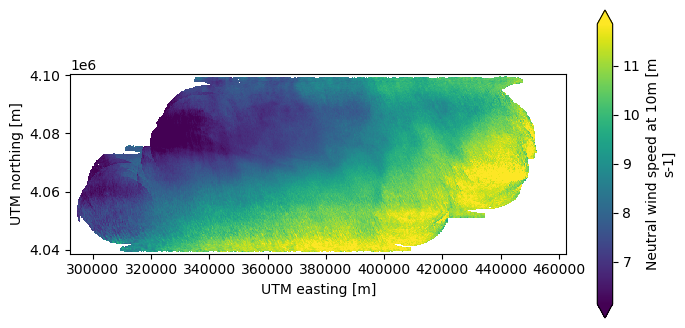

In [390]:
fig, ax = plt.subplots(figsize = (8, 4))
ds.wind_speed_all_lines.plot(x = "x", y = "y", robust = True)
ax.axis("scaled")

Now let's take a look at the u and v ocean current velocities.

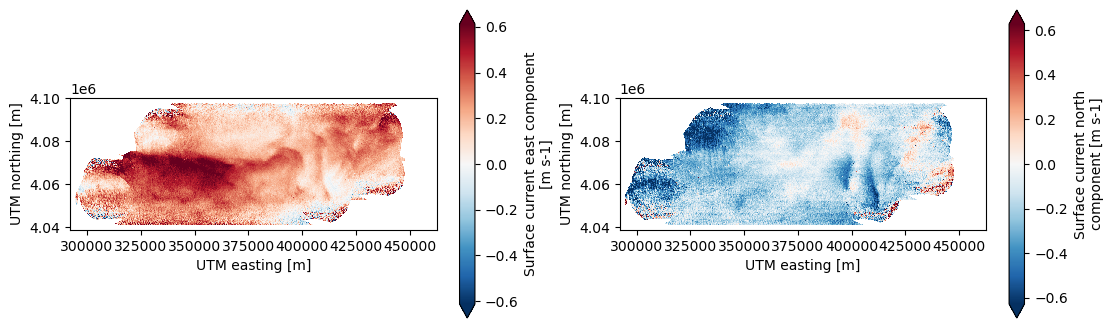

In [391]:
fig, ax = plt.subplots(1, 2, figsize = (13, 4))
ds["u_current_all_lines"].plot(ax = ax[0], x = "x", y = "y", robust = True)
ds["v_current_all_lines"].plot(ax = ax[1], x = "x", y = "y", robust = True)
[a.axis("scaled") for a in ax];

We can notice that the veloticites are kind of weird in the edges, and we can check and use the error to estimate how much we can trust them.

(292223.9500801831, 462587.1433237919, 4038690.994225785, 4100277.6884933207)

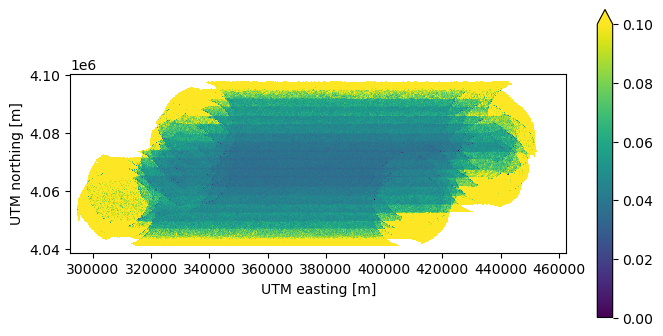

In [392]:
error = np.sqrt(ds["u_current_error_all_lines"]**2 + ds["v_current_error_all_lines"]**2)

fig, ax = plt.subplots(figsize = (8, 4))
error.plot(x = "x", y = "y", vmin = 0, vmax = 0.1)
ax.axis("scaled")


Let's remove data with error higher than 0.1 m/s, but before that, let's apply a smoothing filter to the error 

In [393]:
ds = ds.assign(
    u_current_all_lines = ds.u_current_all_lines.where(error < 0.1),
    v_current_all_lines = ds.v_current_all_lines.where(error < 0.1),
)

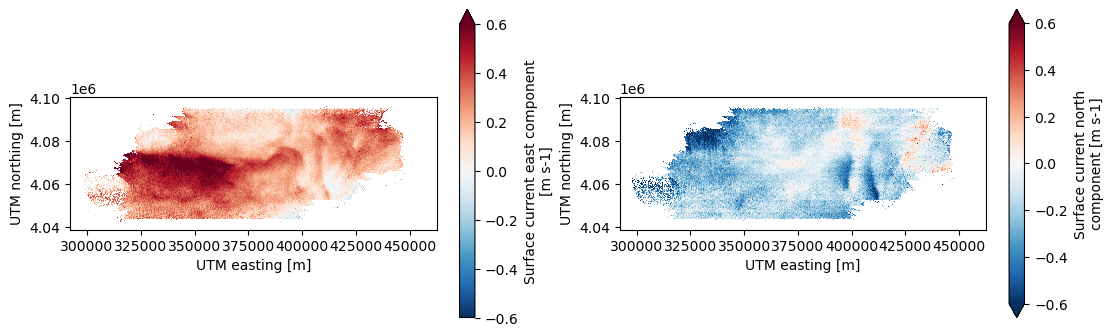

In [396]:
kw = dict(x = "x", y = "y", vmin = -0.6, vmax = 0.6, cmap = "RdBu_r")

fig, ax = plt.subplots(1, 2, figsize = (13, 4))
ds["u_current_all_lines"].plot(ax = ax[0], **kw)
ds["v_current_all_lines"].plot(ax = ax[1], **kw)
[a.axis("scaled") for a in ax];

xarray has methods for differentiating, as we used for the drifters. Here, we can use it to estimate $\zeta/f = (\dfrac{\partial v}{\partial x} - \dfrac{\partial u}{\partial y})/f$

(292223.9500801831, 462587.1433237919, 4038690.994225785, 4100277.6884933207)

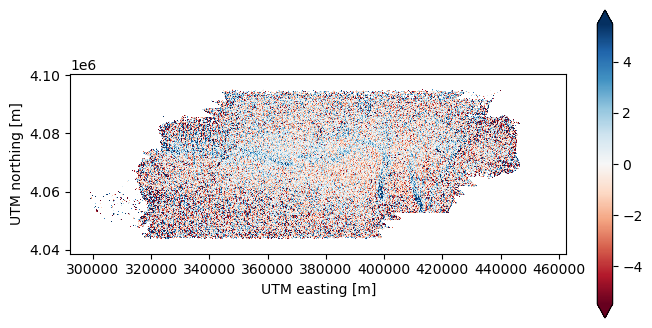

In [397]:
import gsw

zeta = (ds["v_current_all_lines"].differentiate("x") - ds["u_current_all_lines"].differentiate("y")) / gsw.f(ds.latitude.mean())

fig, ax = plt.subplots(figsize = (8, 4))
zeta.plot(x = "x", y = "y", robust = True, cmap = "RdBu")
ax.axis("scaled")

This is looking very noisy, lets apply a boxcar (rolling mean) filter to the data with centered window of 11 points (2 km).

(292223.9500801831, 462587.1433237919, 4038690.994225785, 4100277.6884933207)

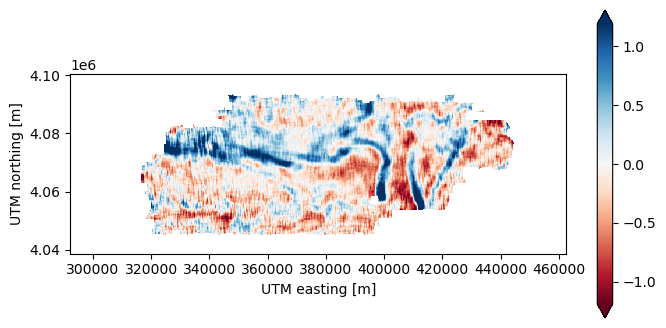

In [401]:
window = 11
filter = lambda da: da.rolling(x = window, y = window, center = True).mean()

zeta = filter(zeta)

fig, ax = plt.subplots(figsize = (8, 4))
zeta.plot(x = "x", y = "y", robust = True, cmap = "RdBu")
ax.axis("scaled")

We can also plot streamlines for the velocity field on top of the vorticity

(292223.9500801831, 462587.1433237919, 4038690.994225785, 4100277.6884933207)

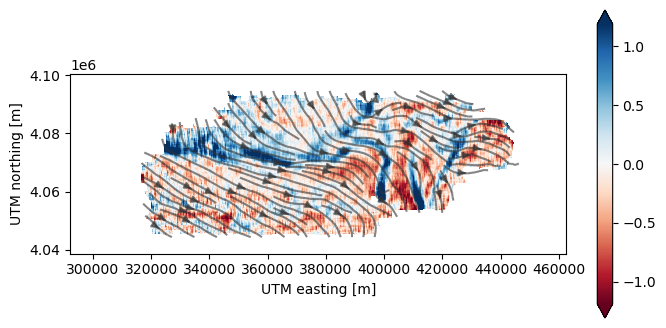

In [414]:
fig, ax = plt.subplots(figsize = (8, 4))
zeta.plot(x = "x", y = "y", robust = True, cmap = "RdBu")
ds.plot.streamplot(x = "x", y = "y", u = "u_current_all_lines", v = "v_current_all_lines", density = 1.5, color = (0.2,0.2,0.2,0.6))
ax.axis("scaled")

## Merging the two datasets

Now we need to merge the two datasets into a single plot.
To do that, although DopplerScatt also has latitude and longitudes as coordinates, we can convert the WGS latitude and longitude from drifter data to UTM10 using `pyproj`.

In [416]:
from pyproj import Transformer

wgs2utm = Transformer.from_crs("EPSG:4326", "EPSG:32610").transform # x, y = f(lat, lon)

x, y = wgs2utm(drifters.latitude, drifters.longitude)
x[np.isinf(x)] = np.nan
y[np.isinf(y)] = np.nan

drifters = drifters.assign_coords(
    x = (("drifter", "obs"), x),
    y = (("drifter", "obs"), y),
)

Using the the time range of 2 days centered in the mean time of the DopplerScatt data, we can select the drifter data and overlay to the previous plot.

In [417]:
tmin = ds.mean_line_time.mean() - np.timedelta64(24, "h")
tmax = ds.mean_line_time.mean() + np.timedelta64(24, "h")

dfi = drifters.copy().reset_coords(["latitude", "longitude", "x", "y"])
where = (dfi.time > tmin) & (dfi.time < tmax)
dfi = dfi.where(where).set_coords(["latitude", "longitude", "x", "y"])

[(292323.9284799739, 462487.16492400103),
 (4038790.9726255704, 4100177.710093536)]

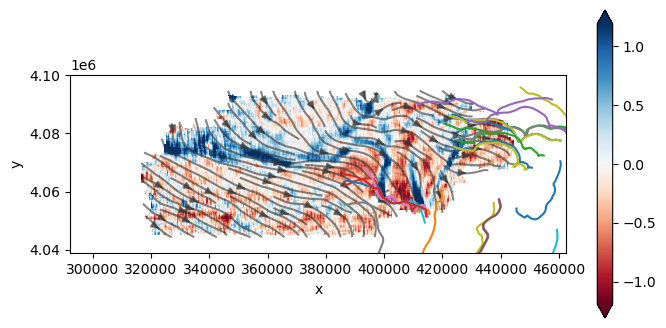

In [426]:
fig, ax = plt.subplots(figsize = (8, 4))
zeta.plot(x = "x", y = "y", robust = True, cmap = "RdBu")
ds.plot.streamplot(x = "x", y = "y", u = "u_current_all_lines", v = "v_current_all_lines", density = 1.5, color = (0.2,0.2,0.2,0.6))
dfi['y'].plot(x = 'x', hue = 'drifter', add_legend = False);
ax.axis("scaled")
ax.set(
    xlim = zeta.x.quantile([0, 1]).values,
    ylim = zeta.y.quantile([0, 1]).values
)

Another way would be to plot the 4km coarsened velocity field from DopplerScatt with drifter-based velocities.

[(309340.25212437665, 445470.8412795983),
 (4038790.9726255704, 4100177.710093536)]

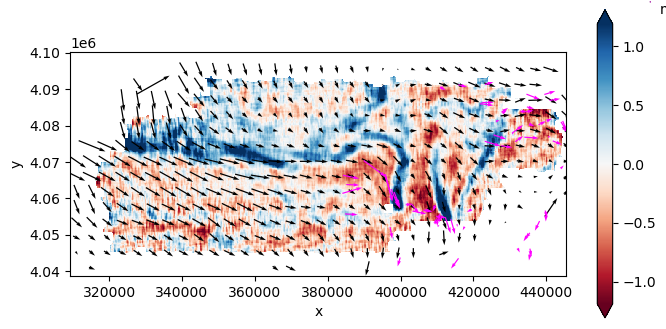

In [427]:
fig, ax = plt.subplots(figsize = (8, 4))
zeta.plot(x = "x", y = "y", robust = True, cmap = "RdBu")
ds.coarsen(x = 21, y = 21, boundary = "trim").mean().plot.quiver(x = "x", y = "y", u = "u_current_all_lines", v = "v_current_all_lines")
dfi.isel(obs = slice(None, None, 100)).plot.quiver(x = "x", y = "y", u = "u", v = "v", scale = 15, color = "magenta")
ax.axis("scaled")
ax.set(
    xlim = zeta.x.quantile([0.1, 0.9]).values,
    ylim = zeta.y.quantile([0, 1]).values
)